# Basic working examples of parameter estimation

In [1]:
using Revise
using DifferentialEquations
using Thyrosim
using Plots
using DiffEqCallbacks
using Optim

┌ Info: Recompiling stale cache file /Users/biona001/.julia/compiled/v1.0/Thyrosim/Oo7R6.ji for Thyrosim [7ef34fca-2b35-11e9-1aeb-a527bedb189e]
└ @ Base loading.jl:1190


## Import data and initial conditions

In [2]:
my_time, my400_data, my450_data, my600_data = blakesley_data()
ic, p = initialize_original_thyrosim() # blakesley patients are not hypothyroid 
tspan = (my_time[1], my_time[end])

(0.0, 120.0)

## Define ODE and related functions

In [15]:
function condition(u, t, integrator)
    return t - 24.0
end

# 400 mcg of oral T4
function affect!(integrator)
    T4_dose = 400.0 / 777.0  
    T3_dose = 0.0
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
#     integrator.u[11] += T4_dose
#     integrator.u[13] += T3_dose
    integrator.u[10] += T4_dose
    integrator.u[12] += T3_dose
end

# gives dose at hour 24
cbk = ContinuousCallback(condition, affect!);

# ODE problem
prob = ODEProblem(original_thyrosim,ic,tspan,p,callback=cbk)

# only calculate TSH error
cost_function = build_loss_objective(prob,Tsit5(),L2Loss(my_time, my400_data[:, 3]),
                                     maxiters=10000,verbose=false, save_idxs=[7])

(::DiffEqObjective{getfield(DiffEqParamEstim, Symbol("##43#48")){Nothing,Bool,Int64,typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR),Base.Iterators.Pairs{Symbol,Any,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:maxiters, :verbose, :save_idxs),Tuple{Int64,Bool,Array{Int64,1}}}},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},ODEFunction{true,typeof(original_thyrosim),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},ContinuousCallback{typeof(condition),typeof(affect!),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing},DiffEqBase.StandardODEProblem},Tsit5,L2Loss{Array{Float64,1},Array{Float64,2},Nothing,Nothing,Nothing},Nothing},getfield(DiffEqParamEstim, Symbol("##47#53"))}) (generic function with 2 methods)

## Write optimization routines 

Read about closures [here](http://julianlsolvers.github.io/Optim.jl/latest/#user/tipsandtricks/#_top). 

In [16]:
fitting_index = [30, 31]
dial = [1.0; 0.88; 1.0; 0.88]
function closure(p, fitting_index, dial)
    reset_p!(p, fitting_index, dial)
    return cost_function(p)
end

# optimize p on fitting index using the default algorithm BFGS()
result = optimize(p -> closure(p, fitting_index, dial), p, BFGS())

# inspect result
result.minimizer[fitting_index]

2-element Array{Float64,1}:
 1212.197189961693 
  519.8640239707134

# Now optimize over 3 sets of T4 oral dose

In [17]:
# calculate TSH error for 400, 450, and 600 datasets
cost_function_400 = build_loss_objective(prob,Tsit5(),L2Loss(my_time, my400_data[:, 3]),
                                     maxiters=10000,verbose=false, save_idxs=[7])

cost_function_450 = build_loss_objective(prob,Tsit5(),L2Loss(my_time, my450_data[:, 3]),
                                     maxiters=10000,verbose=false, save_idxs=[7])

cost_function_600 = build_loss_objective(prob,Tsit5(),L2Loss(my_time, my600_data[:, 3]),
                                     maxiters=10000,verbose=false, save_idxs=[7])

(::DiffEqObjective{getfield(DiffEqParamEstim, Symbol("##43#48")){Nothing,Bool,Int64,typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR),Base.Iterators.Pairs{Symbol,Any,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:maxiters, :verbose, :save_idxs),Tuple{Int64,Bool,Array{Int64,1}}}},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},ODEFunction{true,typeof(original_thyrosim),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},ContinuousCallback{typeof(condition),typeof(affect!),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing},DiffEqBase.StandardODEProblem},Tsit5,L2Loss{Array{Float64,1},Array{Float64,2},Nothing,Nothing,Nothing},Nothing},getfield(DiffEqParamEstim, Symbol("##47#53"))}) (generic function with 2 methods)

In [18]:
fitting_index = [30, 31]
dial = [1.0; 0.88; 1.0; 0.88]
function closure(p, fitting_index, dial)
    reset_p!(p, fitting_index, dial)
    return cost_function_400(p) + cost_function_450(p) + cost_function_600(p)
end

closure (generic function with 1 method)

In [19]:
# optimize p on fitting index using the default algorithm BFGS()
result = optimize(p -> closure(p, fitting_index, dial), p, BFGS())

 * Status: success

 * Candidate solution
    Minimizer: [1.74e-03, 8.00e+00, 8.68e-01,  ...]
    Minimum:   2.215627e+01

 * Found with
    Algorithm:     BFGS
    Initial Point: [1.74e-03, 8.00e+00, 8.68e-01,  ...]

 * Convergence measures
    |x - x'|               = 3.33e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.63e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.86e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.19e-13 ≰ 0.0e+00
    |g(x)|                 = 7.06e-11 ≤ 1.0e-08

 * Work counters
    Iterations:    5
    f(x) calls:    23
    ∇f(x) calls:   23


In [20]:
# inspect result
result.minimizer[fitting_index]

2-element Array{Float64,1}:
 1216.2281883804667 
  503.01657357821523

In [21]:
# some code for plotting
function plot_blakesley(sol, which="400")
    markersize = 2
    t_data, data400, data450, data600 = blakesley_data()
    if which == "400"
        data = data400
    elseif which == "450"
        data = data450
    else
        data = data600
    end
    
    t_data = t_data / 24.0

    ## Need to change to pick better y limits!
    p = sol.prob.p 
    p1 = plot(sol.t / 24.0, 777.0 * sol[1, :] / p[47], ylim=(0, 140), label="",
       ylabel="T4", title="Thyrosim simulation (Blakesley data)")
    p1 = hline!([45, 105], label= "")
    p1 = scatter!(t_data, data[:, 1], label="", markersize=markersize)
    
    p2 = plot(sol.t / 24.0, 651.0 * sol[4, :] / p[47], ylim=(0, 4), label="", 
       ylabel="T3")
    p2 = hline!([0.6, 1.8], label= "")
    p2 = scatter!(t_data, data[:, 2], label="", markersize=markersize)
    
    p3 = plot(sol.t / 24.0, 5.6 * sol[7, :] / p[48], ylim=(0, 10), label="",
       ylabel="TSH", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], label= "")
    p3 = scatter!(t_data, data[:, 3], label="", markersize=markersize)
    
    plot(p1, p2, p3, layout=(3, 1))
end

plot_blakesley (generic function with 2 methods)

In [22]:
# check if fitting is better by plotting
new_prob = ODEProblem(original_thyrosim,ic,tspan,result.minimizer,callback=cbk)
old_sol  = solve(prob)
new_sol  = solve(new_prob);

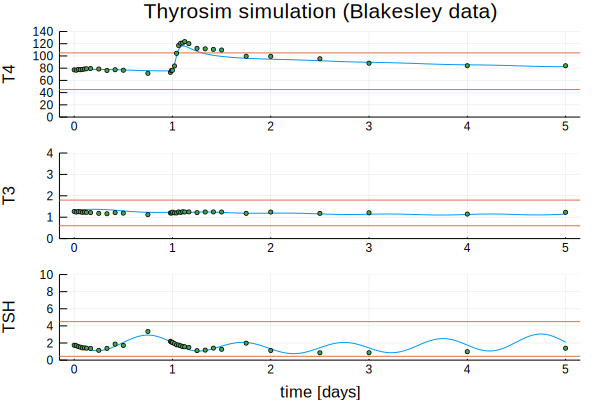

In [23]:
plot_blakesley(old_sol, "400")

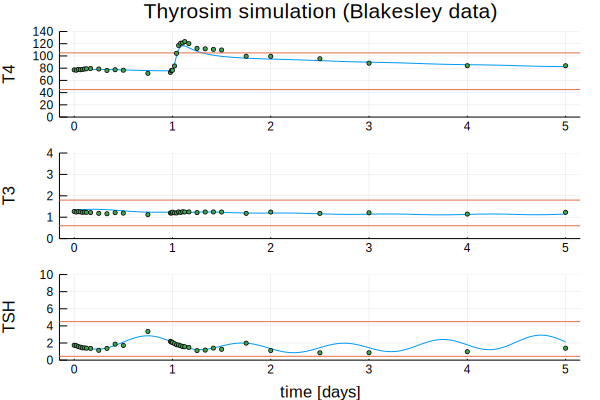

In [24]:
plot_blakesley(new_sol, "400")